# Popularity Prediction

Often times, songs go unappreciated by the world due to lack of promotion. Because of this, I will create a prediction machine that will input songs with low popularity and output a prediction of what their popularity would be if it had the same promotion of the top tier of songs. It will do this by comparing the unpopular song features to the features from popular songs.

## Import the functions

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import the data

In [137]:
PATH = "SpotifyFeatures.csv"
df = pd.read_csv(PATH)
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


For the sake of consistency, we will pick one genre. I have chosen Hip Hop because of its popularity.

In [138]:
hh = df[(df["genre"] == "Hip-Hop")]
hh.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
106034,Hip-Hop,J. Cole,MIDDLE CHILD,2JvzF1RMd7lE3KmFlsyZD8,96,0.14900,0.837,213594,0.364,0.00000,G#,0.2710,-11.713,Major,0.2760,123.984,4/4,0.463
106035,Hip-Hop,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95,0.25900,0.889,180522,0.496,0.00000,E,0.2520,-6.365,Minor,0.0905,86.003,4/4,0.544
106036,Hip-Hop,21 Savage,a lot,2t8yVaLvJ0RenpXUIAC52d,93,0.03950,0.837,288624,0.636,0.00125,C#,0.3420,-7.643,Major,0.0860,145.972,4/4,0.274
106037,Hip-Hop,Rich The Kid,Splashin,79OEIr4J4FHV0O3KrhaXRb,88,0.00195,0.942,177806,0.383,0.00000,A#,0.0922,-8.099,Major,0.5650,100.021,4/4,0.380
106038,Hip-Hop,Sheck Wes,Mo Bamba,1xzBco0xcoJEDXktl7Jxrr,92,0.19400,0.729,183907,0.625,0.00986,E,0.2480,-5.266,Major,0.0315,146.034,4/4,0.261


### Histogram of songs by **Popularity**

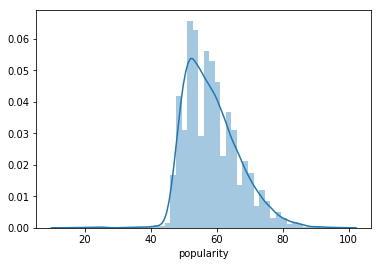

In [139]:
sns.distplot(hh["popularity"])

In [140]:
hh["popularity"].describe()

count    9295.000000
mean       58.423131
std         8.269761
min        14.000000
25%        52.000000
50%        57.000000
75%        63.000000
max        98.000000
Name: popularity, dtype: float64

We want to use the top 10% of songs to train our model. We need to find what the 99th percentile for Popularity is.

In [111]:
np.percentile(hh["popularity"], 90)

70.0

In [112]:
hp = hh[(hh["popularity"] >= 70)]
len(hp)

973

## Find coorelation

<Figure size 864x864 with 0 Axes>

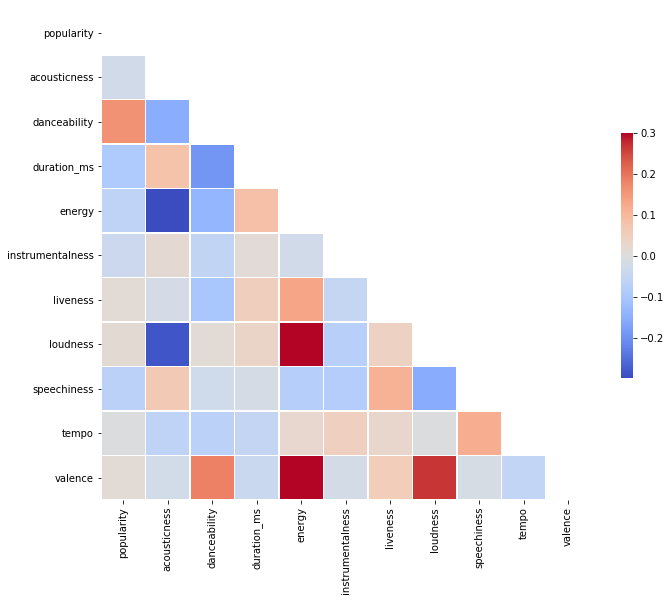

In [113]:
corr = hp.corr().round(3)
plt.figure(figsize=(12,12))
# sns.heatmap(data=corr, annot=True, cmap=plt.cm.Reds)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Notes:
Looks like acousticness has negative coorelation with loudness and energy.
Energy and Loudness have positive coorelation.
Danceability and popularity have high coorelation.
Duration and instrumentalness don't seem to affect anything.

## Feature Selection

Let's find the features with the highest coorelation to popularity, energy, and loudness.

In [114]:
# Correlation with Popularity
target = abs(corr["popularity"])

# Selecting highly correlated features
relevant_features = target[target > 0.05]
relevant_features

popularity      1.000
danceability    0.162
duration_ms     0.088
energy          0.061
speechiness     0.067
Name: popularity, dtype: float64

## Training the Model

Use 75 percent of the data for train part. 
Use 25 percent of the data for test part.

In [115]:
feature_cols = ['danceability', 'duration_ms', 'energy', 'speechiness', 'loudness']
X = hp[feature_cols]
y = hp['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(f"X:{len(X)*.75} should equal X Train:{len(X_train)}")

X:729.75 should equal X Train:729


### Scale the Data

In [116]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
X_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Building the Linear Regression Model

In [117]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

# fit model
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [118]:
print(linreg.coef_)
print(linreg.intercept_)

[ 2.91926685e+00 -5.04753894e-06 -3.77955625e+00 -1.97646236e+00
  2.45997536e-01]
78.21173635053836


In [119]:
X_test.head()

,danceability,duration_ms,energy,speechiness,loudness
107186,0.895,230000,0.694,0.2750,-4.384
106177,0.788,207853,0.771,0.0563,-3.206
106567,0.773,211960,0.564,0.2490,-7.241
106350,0.727,169979,0.620,0.3060,-6.443
114830,0.870,176018,0.542,0.0397,-6.959


In [120]:
y_pred = linreg.predict(X_test)

In [121]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(f"R2 Score = {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred)}")

R2 Score = 0.04926297132033031
Mean Squared Error = 23.71904922390054


## Predict

## Test

In [122]:
y_pred

array([75.41855384, 75.64899171, 74.99337626, 74.94298324, 76.0241589 ,
       76.27426926, 75.13235991, 74.68478713, 73.90434204, 74.75907379,
       75.23797041, 76.38592623, 75.52673188, 74.88724793, 74.90075804,
       74.43470547, 74.97465799, 74.88835715, 75.27233633, 75.8705051 ,
       75.66253851, 74.14346306, 75.64402891, 75.12430156, 74.6980184 ,
       75.43427882, 75.50042256, 75.81509469, 73.71362416, 74.7653527 ,
       75.42640488, 75.05783232, 74.136075  , 75.13232664, 75.23123091,
       74.6454359 , 75.63606945, 75.85851943, 75.5030469 , 75.18707449,
       75.66328919, 74.23414105, 75.40601221, 73.52260388, 75.47548911,
       73.63118559, 75.05856303, 75.44446058, 74.25861065, 72.81176305,
       75.46455144, 75.37744521, 75.67329993, 74.81940745, 75.54782005,
       74.32425008, 75.33984012, 74.60355559, 73.62845707, 75.64524822,
       74.29796774, 74.57895719, 73.95171176, 74.63665485, 75.05541873,
       73.03136691, 75.74724968, 74.92388708, 74.278501  , 74.90

Most of the predictions are in the 70's which indicated the model doesn't output much variety

In [141]:
X.head()

,danceability,duration_ms,energy,speechiness,loudness
106034,0.837,213594,0.364,0.2760,-11.713
106035,0.889,180522,0.496,0.0905,-6.365
106036,0.837,288624,0.636,0.0860,-7.643
106037,0.942,177806,0.383,0.5650,-8.099
106038,0.729,183907,0.625,0.0315,-5.266


In [124]:
y.head()

106034    96
106035    95
106036    93
106037    88
106038    92
Name: popularity, dtype: int64

Lets take an unpopular hip hop song

In [142]:
hh.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
106034,Hip-Hop,J. Cole,MIDDLE CHILD,2JvzF1RMd7lE3KmFlsyZD8,96,0.14900,0.837,213594,0.364,0.00000,G#,0.2710,-11.713,Major,0.2760,123.984,4/4,0.463
106035,Hip-Hop,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95,0.25900,0.889,180522,0.496,0.00000,E,0.2520,-6.365,Minor,0.0905,86.003,4/4,0.544
106036,Hip-Hop,21 Savage,a lot,2t8yVaLvJ0RenpXUIAC52d,93,0.03950,0.837,288624,0.636,0.00125,C#,0.3420,-7.643,Major,0.0860,145.972,4/4,0.274
106037,Hip-Hop,Rich The Kid,Splashin,79OEIr4J4FHV0O3KrhaXRb,88,0.00195,0.942,177806,0.383,0.00000,A#,0.0922,-8.099,Major,0.5650,100.021,4/4,0.380
106038,Hip-Hop,Sheck Wes,Mo Bamba,1xzBco0xcoJEDXktl7Jxrr,92,0.19400,0.729,183907,0.625,0.00986,E,0.2480,-5.266,Major,0.0315,146.034,4/4,0.261


In [147]:
hl = hh[(hh["popularity"] <= 30)]
len(hl)

15

In [150]:
hl.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
109279,Hip-Hop,Waka Flocka Flame,Turn It To A Rave (feat. Neon Dreams),63NR3HIWhrQoYiqp7xJOzH,25,0.0880,0.691,232720,0.699,0.000014,F#,0.322,-9.745,Minor,0.0844,130.238,4/4,0.374
109281,Hip-Hop,Waka Flocka Flame,Turn Up God (Intro),5MVQP1V1OIXIVeLeaP0TPq,26,0.0547,0.639,228880,0.865,0.000000,G#,0.507,-13.918,Minor,0.0718,133.052,4/4,0.401
109283,Hip-Hop,Waka Flocka Flame,Grove St. Party (feat. Neon Dreams),1eSt469YITAg1DAEgXxleU,24,0.0411,0.589,134200,0.661,0.000000,F#,0.606,-9.402,Major,0.2270,143.537,4/4,0.697
109286,Hip-Hop,Waka Flocka Flame,"OVA (feat. DJ Whoo Kid, Offset & Ca$h Out)",0V3jsjVLndqsGgm77L1ALn,23,0.1210,0.772,269427,0.484,0.000000,B,0.179,-10.103,Major,0.1140,135.956,4/4,0.334
109288,Hip-Hop,Waka Flocka Flame,Go Crazy (feat. Machine Gun Kelly),0tQuTpN6nptWmrAy9l99VY,25,0.2300,0.791,187747,0.820,0.000000,C#,0.575,-7.480,Major,0.2220,133.264,4/4,0.635


In [154]:
feature_cols = ['danceability', 'duration_ms', 'energy', 'speechiness', 'loudness']
hx = hl[feature_cols]
# hy = hl["popularity"]

In [156]:
y_pred = linreg.predict(hx)
y_pred

array([73.84831725, 72.08684729, 73.99399233, 74.56553204, 74.19514379,
       74.58419197, 73.64904653, 72.67842683, 73.67151408, 72.03245585,
       73.79482079, 73.79778748, 72.92119664, 74.04809867, 74.31068507])

We successfully estimated how popular a song would be if they had proper promotion!